In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

In [33]:
# SHAP for interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Skipping SHAP analysis.\n")

SHAP not installed. Skipping SHAP analysis.



In [34]:
df = pd.read_csv('../Data/digital_marketing_campaign_dataset.csv')

In [35]:
df.head(10)

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1
5,8005,25,Female,42925,Social Media,Awareness,9579.388247,0.153795,0.161316,6,2.125850,7.752831,95,5,8,0,3316,IsConfid,ToolConfid,1
6,8006,38,Female,25615,Referral,Awareness,7302.899852,0.040975,0.060977,42,1.753995,10.698672,54,14,3,6,930,IsConfid,ToolConfid,1
7,8007,56,Female,57083,Social Media,Conversion,5324.283667,0.052878,0.188946,48,2.626015,2.987817,96,9,3,0,2983,IsConfid,ToolConfid,1
8,8008,36,Female,140788,Email,Retention,9421.250951,0.023536,0.112585,13,5.472843,14.287421,73,4,8,5,460,IsConfid,ToolConfid,1
9,8009,40,Male,130764,Social Media,Awareness,6229.193333,0.066641,0.169786,22,1.135665,4.613312,14,8,4,8,3789,IsConfid,ToolConfid,1


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [37]:
df.isnull().sum()

CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64

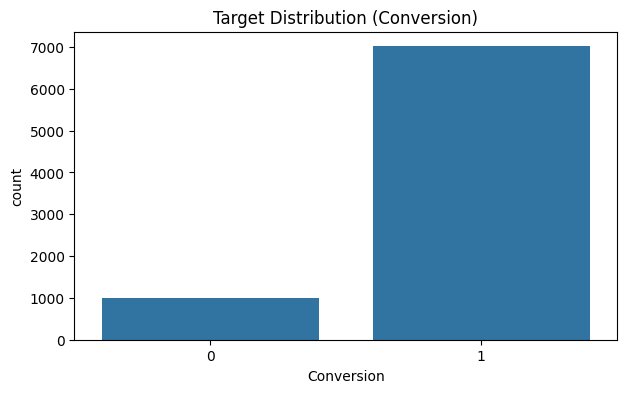

In [38]:
# Plot distribution of target (assuming 'Conversion' is 0/1)
plt.figure(figsize=(7, 4))
sns.countplot(data=df, x="Conversion")
plt.title("Target Distribution (Conversion)")
plt.show()

<Figure size 1000x600 with 0 Axes>

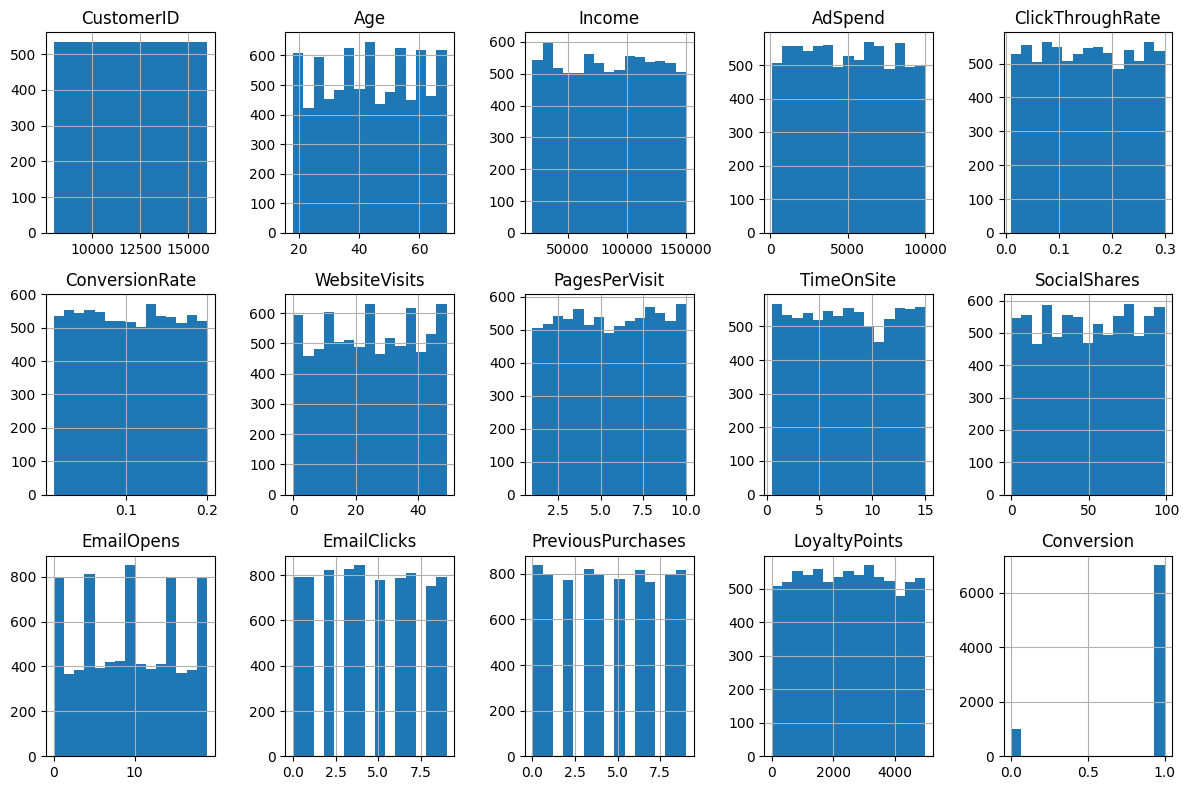

In [39]:
# Quick look at a few potential numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(10, 6))
df[numeric_cols].hist(figsize=(12, 8), bins=15, layout=(3, 5))
plt.tight_layout()
plt.show()

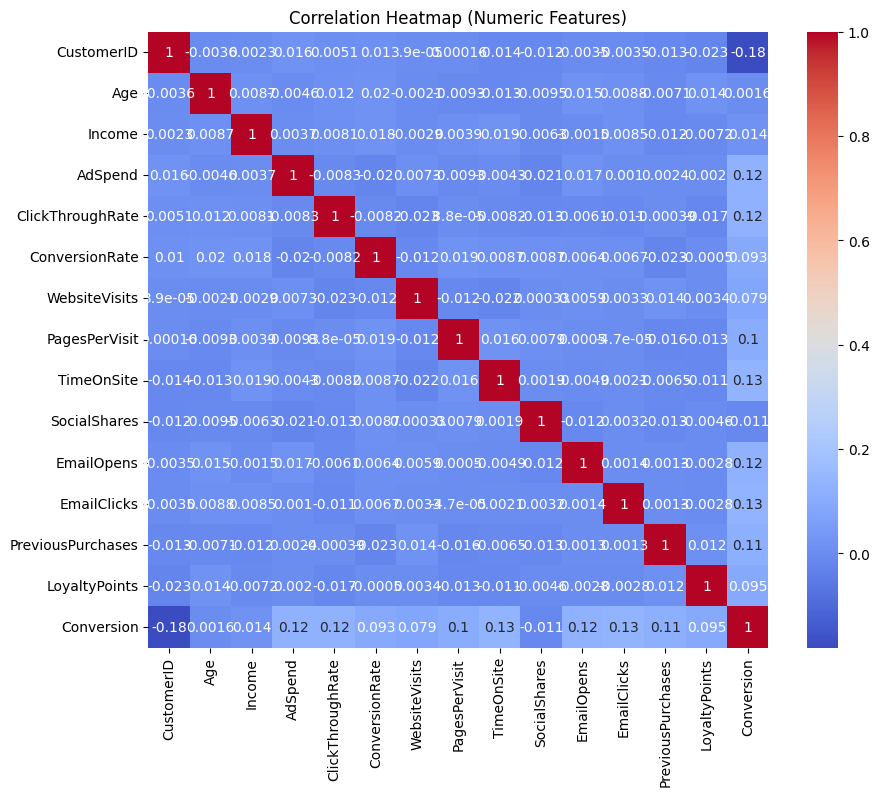

In [40]:
# Correlation heatmap for numeric features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [41]:
# Drop ID column
df.drop(columns=["CustomerID"], inplace=True)

In [42]:
TARGET = "Conversion"
X = df.drop(columns=[TARGET])
y = df[TARGET]

In [44]:
# Identify categorical vs numeric
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

In [45]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ]
)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [49]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
}

# Let's do GridSearch for 1 or 2 models (demonstration)
param_grid_rf = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [3, 5]
}

param_grid_gb = {
    "classifier__n_estimators": [100, 200],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [3, 5]
}

search_spaces = {
    "RandomForest": param_grid_rf,
    "GradientBoosting": param_grid_gb
}

best_estimators = {}
for model_name, model in models.items():
    # Build pipeline
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    if model_name in search_spaces:
        # GridSearch for selected models
        print(f"\n===== GRIDSEARCH for {model_name} =====")
        gs = GridSearchCV(
            pipe, search_spaces[model_name],
            scoring="roc_auc", cv=3, verbose=1
        )
        gs.fit(X_train, y_train)
        print(f"BEST PARAMS for {model_name}: {gs.best_params_}")
        best_estimators[model_name] = gs.best_estimator_
    else:
        # Simple fit for other models
        pipe.fit(X_train, y_train)
        best_estimators[model_name] = pipe


===== GRIDSEARCH for RandomForest =====
Fitting 3 folds for each of 4 candidates, totalling 12 fits
BEST PARAMS for RandomForest: {'classifier__max_depth': 5, 'classifier__n_estimators': 200}

===== GRIDSEARCH for GradientBoosting =====
Fitting 3 folds for each of 8 candidates, totalling 24 fits
BEST PARAMS for GradientBoosting: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:32:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Evaluating LogisticRegression...
Accuracy: 0.8912
ROC-AUC: 0.7850
Confusion Matrix:
 [[  34  164]
 [  10 1392]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.17      0.28       198
           1       0.89      0.99      0.94      1402

    accuracy                           0.89      1600
   macro avg       0.83      0.58      0.61      1600
weighted avg       0.88      0.89      0.86      1600



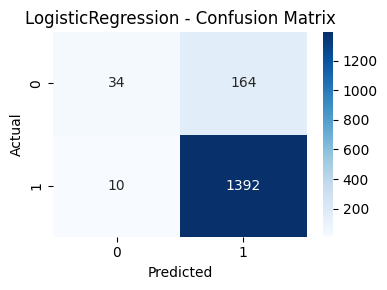


Evaluating RandomForest...
Accuracy: 0.8775
ROC-AUC: 0.8126
Confusion Matrix:
 [[   3  195]
 [   1 1401]]
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.02      0.03       198
           1       0.88      1.00      0.93      1402

    accuracy                           0.88      1600
   macro avg       0.81      0.51      0.48      1600
weighted avg       0.86      0.88      0.82      1600



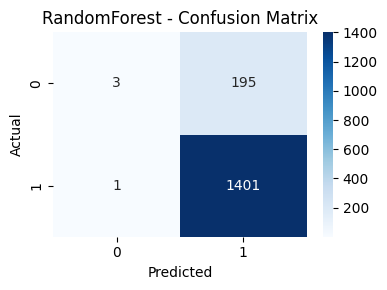


Evaluating GradientBoosting...
Accuracy: 0.9100
ROC-AUC: 0.8168
Confusion Matrix:
 [[  66  132]
 [  12 1390]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.33      0.48       198
           1       0.91      0.99      0.95      1402

    accuracy                           0.91      1600
   macro avg       0.88      0.66      0.71      1600
weighted avg       0.90      0.91      0.89      1600



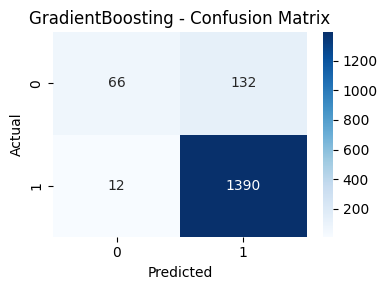


Evaluating XGBoost...
Accuracy: 0.9144
ROC-AUC: 0.7981
Confusion Matrix:
 [[  79  119]
 [  18 1384]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.40      0.54       198
           1       0.92      0.99      0.95      1402

    accuracy                           0.91      1600
   macro avg       0.87      0.69      0.74      1600
weighted avg       0.91      0.91      0.90      1600



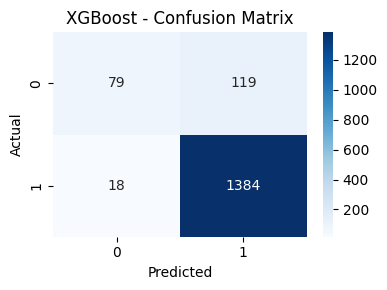

In [51]:
results = {}
for model_name, estimator in best_estimators.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = estimator.predict(X_test)
    if hasattr(estimator.named_steps['classifier'], "predict_proba"):
        y_prob = estimator.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_prob)
    else:
        y_prob = None
        auc_score = None

    acc_score = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    cl_report = classification_report(y_test, y_pred)

    print(f"Accuracy: {acc_score:.4f}")
    if auc_score:
        print(f"ROC-AUC: {auc_score:.4f}")
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", cl_report)

    results[model_name] = {
        "Accuracy": acc_score,
        "ROC-AUC": auc_score,
        "ConfusionMatrix": cm,
        "ClassificationReport": cl_report
    }

    # Plot Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [52]:
# Compare results
print("\n===== MODEL COMPARISON =====")
for model_name, metrics in results.items():
    print(f"{model_name} => Accuracy: {metrics['Accuracy']:.4f}, ROC-AUC: {metrics['ROC-AUC']}")


===== MODEL COMPARISON =====
LogisticRegression => Accuracy: 0.8912, ROC-AUC: 0.7849752878283549
RandomForest => Accuracy: 0.8775, ROC-AUC: 0.812551333592703
GradientBoosting => Accuracy: 0.9100, ROC-AUC: 0.816769694087811
XGBoost => Accuracy: 0.9144, ROC-AUC: 0.7980878687012781



RandomForest Top 10 Features:
1. PagesPerVisit: 0.1277
2. PreviousPurchases: 0.1158
3. ClickThroughRate: 0.1063
4. TimeOnSite: 0.1036
5. AdSpend: 0.0953
6. ConversionRate: 0.0842
7. EmailClicks: 0.0811
8. LoyaltyPoints: 0.0803
9. EmailOpens: 0.0718
10. WebsiteVisits: 0.0575


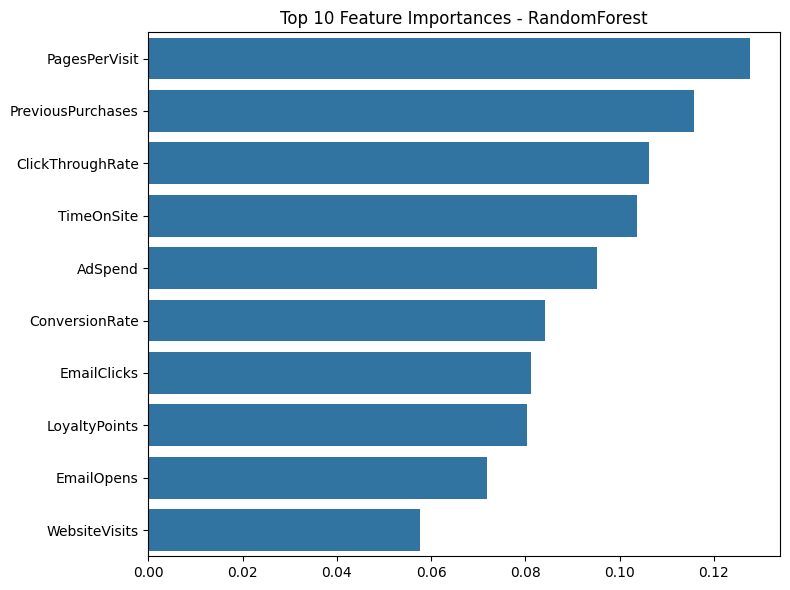


GradientBoosting Top 10 Features:
1. AdSpend: 0.1302
2. TimeOnSite: 0.1231
3. PagesPerVisit: 0.1129
4. ClickThroughRate: 0.1089
5. PreviousPurchases: 0.0974
6. ConversionRate: 0.0932
7. LoyaltyPoints: 0.0789
8. EmailOpens: 0.0730
9. EmailClicks: 0.0727
10. WebsiteVisits: 0.0534


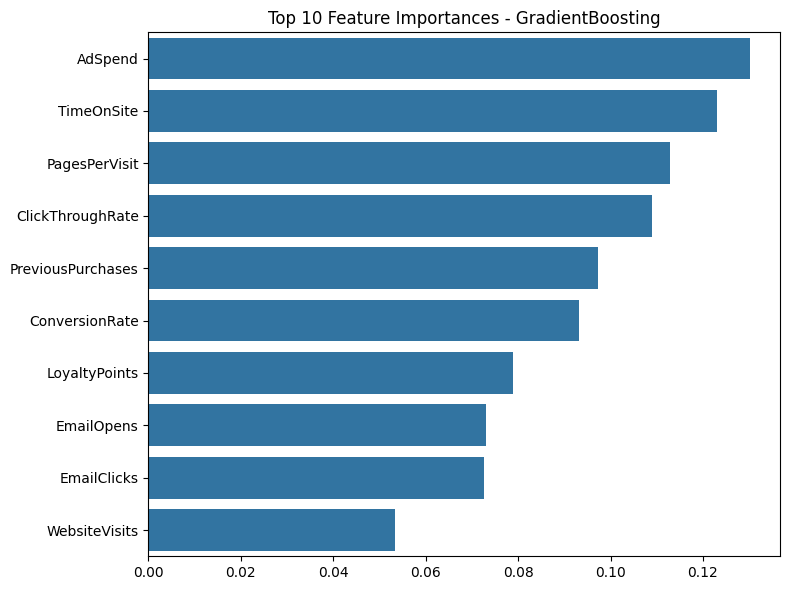


XGBoost Top 10 Features:
1. CampaignType_Conversion: 0.0917
2. EmailClicks: 0.0817
3. PreviousPurchases: 0.0799
4. ClickThroughRate: 0.0628
5. EmailOpens: 0.0588
6. AdSpend: 0.0567
7. PagesPerVisit: 0.0542
8. TimeOnSite: 0.0530
9. ConversionRate: 0.0500
10. LoyaltyPoints: 0.0498


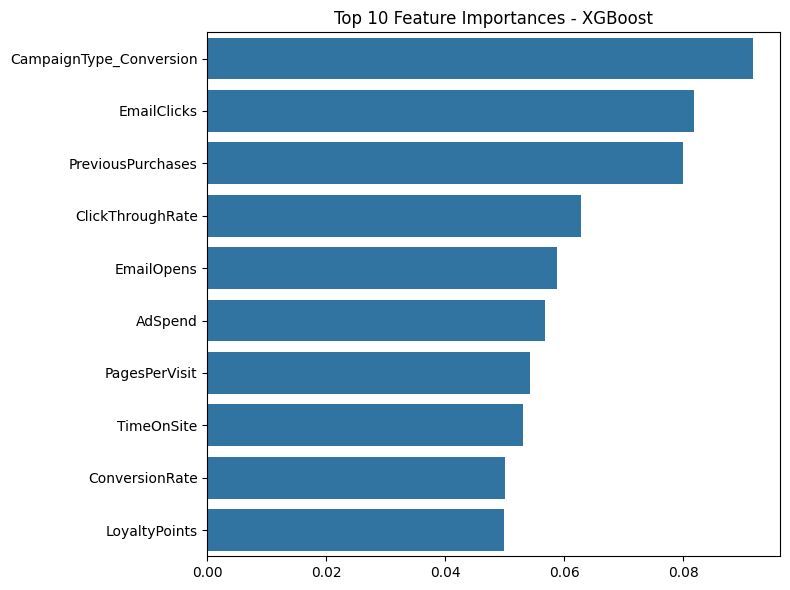

In [53]:
# Example: Evaluate feature importances for tree-based models
tree_models = ["RandomForest", "GradientBoosting", "XGBoost"]
for tm in tree_models:
    if tm in best_estimators:
        clf = best_estimators[tm].named_steps["classifier"]
        # Some models have feature_importances_, others (XGB) have .feature_importances_ or .coef_
        if hasattr(clf, "feature_importances_"):
            # Retrieve feature names from pipeline
            # Preprocessor transforms them, so let's gather them
            feat_names_num = preprocessor.named_transformers_["num"].get_feature_names_out(num_cols)
            feat_names_cat = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
            all_feat_names = np.concatenate((feat_names_num, feat_names_cat))

            importances = clf.feature_importances_
            sorted_idx = np.argsort(importances)[::-1]
            top_n = 10  # display top 10
            print(f"\n{tm} Top {top_n} Features:")
            for i in range(top_n):
                print(f"{i+1}. {all_feat_names[sorted_idx[i]]}: {importances[sorted_idx[i]]:.4f}")

            # Plot top features
            plt.figure(figsize=(8, 6))
            sns.barplot(x=importances[sorted_idx[:top_n]],
                        y=all_feat_names[sorted_idx[:top_n]])
            plt.title(f"Top {top_n} Feature Importances - {tm}")
            plt.tight_layout()
            plt.show()

        # SHAP
        if SHAP_AVAILABLE:
            print(f"\nRunning SHAP analysis for {tm} (first 300 rows for performance)...")
            # Preprocess a sample
            X_sample = X_train[:300]
            y_sample = y_train[:300]
            X_sample_transformed = preprocessor.fit_transform(X_sample, y_sample)

            # Build an explainer
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_sample_transformed)
            shap.summary_plot(shap_values, X_sample_transformed,
                              feature_names=all_feat_names, show=True)
